In [1]:
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib
%matplotlib inline
import seaborn as sns

X = pd.read_csv('/mnt/ml-team/minerva/open-solutions/home-credit/files/unzipped_data/application_train.csv')

In [2]:
X.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Preprocessing
## Solution 3

[Martin Kotek (Competition Host): "Value 365243 denotes infinity in DAYS variables in the datasets, therefore you can consider them NA values. Also XNA/XAP denote NA values."](https://www.kaggle.com/c/home-credit-default-risk/discussion/57247)

In [18]:
X['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [19]:
X.loc[X['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].unique()

array([365243])

In [25]:
sum(X['ORGANIZATION_TYPE'] == 'XNA')

55374

# Feature Engineering
## Solution 3
### Hand crafted features

In [4]:
X['annuity_income_percentage'] = X['AMT_ANNUITY'] / X['AMT_INCOME_TOTAL']
X['car_to_birth_ratio'] = X['OWN_CAR_AGE'] / X['DAYS_BIRTH']
X['car_to_employ_ratio'] = X['OWN_CAR_AGE'] / X['DAYS_EMPLOYED']
X['children_ratio'] = X['CNT_CHILDREN'] / X['CNT_FAM_MEMBERS']
X['credit_to_annuity_ratio'] = X['AMT_CREDIT'] / X['AMT_ANNUITY']
X['credit_to_goods_ratio'] = X['AMT_CREDIT'] / X['AMT_GOODS_PRICE']
X['credit_to_income_ratio'] = X['AMT_CREDIT'] / X['AMT_INCOME_TOTAL']
X['days_employed_percentage'] = X['DAYS_EMPLOYED'] / X['DAYS_BIRTH']
X['ext_sources_mean'] = X[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
X['income_credit_percentage'] = X['AMT_INCOME_TOTAL'] / X['AMT_CREDIT']
X['income_per_child'] = X['AMT_INCOME_TOTAL'] / (1 + X['CNT_CHILDREN'])
X['income_per_person'] = X['AMT_INCOME_TOTAL'] / X['CNT_FAM_MEMBERS']
X['payment_rate'] = X['AMT_ANNUITY'] / X['AMT_CREDIT']
X['phone_to_birth_ratio'] = X['DAYS_LAST_PHONE_CHANGE'] / X['DAYS_BIRTH']
X['phone_to_employ_ratio'] = X['DAYS_LAST_PHONE_CHANGE'] / X['DAYS_EMPLOYED']

In [5]:
engineered_numerical_columns = ['annuity_income_percentage',
                                 'car_to_birth_ratio',
                                 'car_to_employ_ratio',
                                 'children_ratio',
                                 'credit_to_annuity_ratio',
                                 'credit_to_goods_ratio',
                                 'credit_to_income_ratio',
                                 'days_employed_percentage',
                                 'ext_sources_mean',
                                 'income_credit_percentage',
                                 'income_per_child',
                                 'income_per_person',
                                 'payment_rate',
                                 'phone_to_birth_ratio',
                                 'phone_to_employ_ratio']

In [6]:
X_eng = X[engineered_numerical_columns + ['TARGET']]
X_eng_corr = abs(X_eng.corr())

In [7]:
X_eng_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                       1.000000
ext_sources_mean             0.222052
credit_to_goods_ratio        0.069427
car_to_birth_ratio           0.048824
days_employed_percentage     0.042206
phone_to_birth_ratio         0.033991
credit_to_annuity_ratio      0.032102
car_to_employ_ratio          0.030553
children_ratio               0.021223
annuity_income_percentage    0.014265
payment_rate                 0.012704
income_per_child             0.012529
credit_to_income_ratio       0.007727
income_per_person            0.006571
phone_to_employ_ratio        0.004562
income_credit_percentage     0.001817
Name: TARGET, dtype: float64

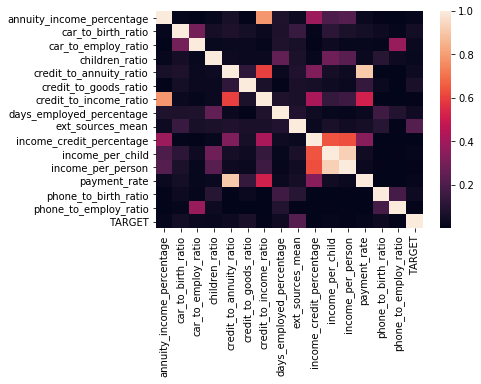

In [8]:
sns.heatmap(X_eng_corr, 
            xticklabels=X_eng_corr.columns,
            yticklabels=X_eng_corr.columns)

### Aggregation features

In [9]:
AGGREGATION_RECIPIES = [
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE'], [('AMT_ANNUITY', 'max'),
                                              ('AMT_CREDIT', 'max'),
                                              ('EXT_SOURCE_1', 'mean'),
                                              ('EXT_SOURCE_2', 'mean'),
                                              ('OWN_CAR_AGE', 'max'),
                                              ('OWN_CAR_AGE', 'sum')]),
    (['CODE_GENDER', 'ORGANIZATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                                            ('AMT_INCOME_TOTAL', 'mean'),
                                            ('DAYS_REGISTRATION', 'mean'),
                                            ('EXT_SOURCE_1', 'mean')]),
    (['CODE_GENDER', 'REG_CITY_NOT_WORK_CITY'], [('AMT_ANNUITY', 'mean'),
                                                 ('CNT_CHILDREN', 'mean'),
                                                 ('DAYS_ID_PUBLISH', 'mean')]),
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('EXT_SOURCE_1', 'mean'),
                                                                                           ('EXT_SOURCE_2', 'mean')]),
    (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE'], [('AMT_CREDIT', 'mean'),
                                                  ('AMT_REQ_CREDIT_BUREAU_YEAR', 'mean'),
                                                  ('APARTMENTS_AVG', 'mean'),
                                                  ('BASEMENTAREA_AVG', 'mean'),
                                                  ('EXT_SOURCE_1', 'mean'),
                                                  ('EXT_SOURCE_2', 'mean'),
                                                  ('EXT_SOURCE_3', 'mean'),
                                                  ('NONLIVINGAREA_AVG', 'mean'),
                                                  ('OWN_CAR_AGE', 'mean'),
                                                  ('YEARS_BUILD_AVG', 'mean')]),
    (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('ELEVATORS_AVG', 'mean'),
                                                                            ('EXT_SOURCE_1', 'mean')]),
    (['OCCUPATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                           ('CNT_CHILDREN', 'mean'),
                           ('CNT_FAM_MEMBERS', 'mean'),
                           ('DAYS_BIRTH', 'mean'),
                           ('DAYS_EMPLOYED', 'mean'),
                           ('DAYS_ID_PUBLISH', 'mean'),
                           ('DAYS_REGISTRATION', 'mean'),
                           ('EXT_SOURCE_1', 'mean'),
                           ('EXT_SOURCE_2', 'mean'),
                           ('EXT_SOURCE_3', 'mean')]),
]

In [10]:
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
    group_object = X.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        X = X.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [11]:
X_agg = X[groupby_aggregate_names + ['TARGET']]
X_agg_corr = abs(X_agg.corr())

In [12]:
X_agg_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                                                                      1.000000
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_1                0.089964
CODE_GENDER_NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_2    0.089235
CODE_GENDER_NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_1    0.086676
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_EXT_SOURCE_1                                       0.083520
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_EXT_SOURCE_2                                       0.082742
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_ELEVATORS_AVG               0.078057
OCCUPATION_TYPE_mean_EXT_SOURCE_1                                                           0.076587
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_AMT_REQ_CREDIT_BUREAU_YEAR                         0.074528
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_YEARS_BUILD_AVG                                   

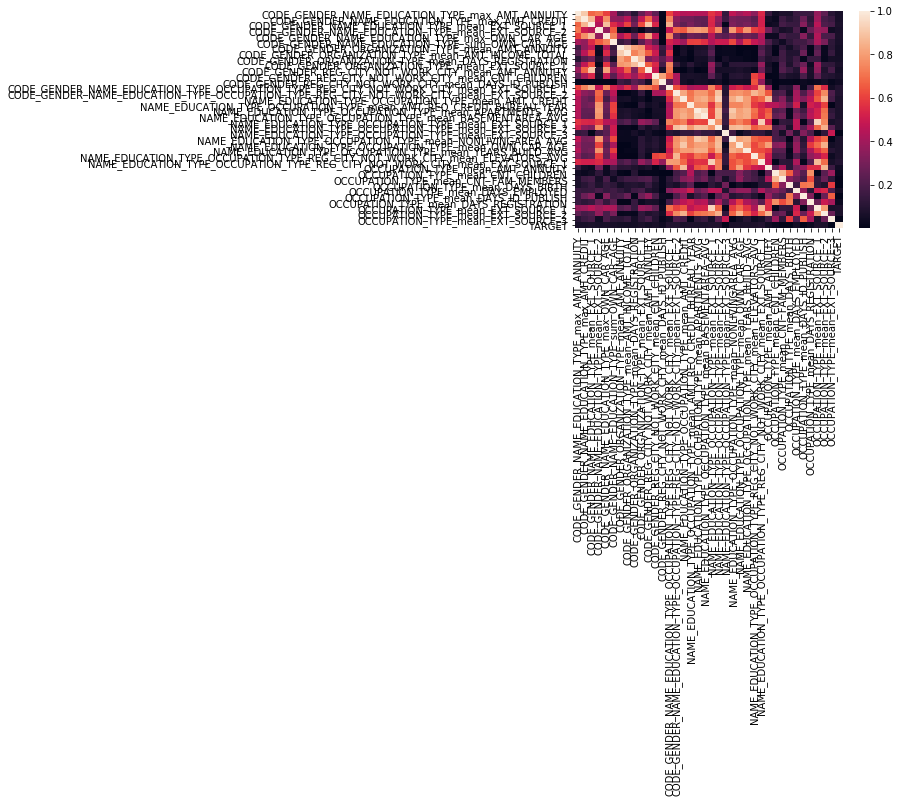

In [13]:
sns.heatmap(X_agg_corr, 
            xticklabels=X_agg_corr.columns,
            yticklabels=X_agg_corr.columns)

## Solution 4 TODO
### Hand crafted features
* Explore other ext_sources features
* Explore unemployed feature